<a href="https://colab.research.google.com/github/Simarjit1303/Data-Science/blob/main/exercises/machine-learning/Big-Data-Analytics/Spam_detection_form_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam detection form kaggle

In [2]:
!pip install --upgrade gensim scipy
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [1]:
import kagglehub
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import display

# EDA

### Loading Data

In [2]:
# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("purusinghvi/email-spam-classification-dataset")
print(f"Dataset downloaded to: {path}")

csv_filename = 'combined_data.csv'

# Construct the full path to the CSV file
csv_file_path = os.path.join(path, csv_filename)

# Load the CSV file into a pandas DataFrame
print(f"\nLoading dataset from: {path}")
df = pd.read_csv(csv_file_path, encoding='latin-1') # Adjust encoding if needed

# --- Display the top 5 rows ---
print("\nTop 5 rows of the dataset:")
display(df.head())

Dataset downloaded to: /kaggle/input/email-spam-classification-dataset

Loading dataset from: /kaggle/input/email-spam-classification-dataset

Top 5 rows of the dataset:


,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [3]:
# --- Understand the column structure ---
print("\nDataset Information:")
df.info()
print("\nColumn names:", df.columns.tolist())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB

Column names: ['label', 'text']


In [5]:
# Counting null values
print("\nMissing values per column:")
df.isna().count()


Missing values per column:


,0
label,83448
text,83448


In [4]:
# --- Define Column Names ---
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label'

### Data Visulization

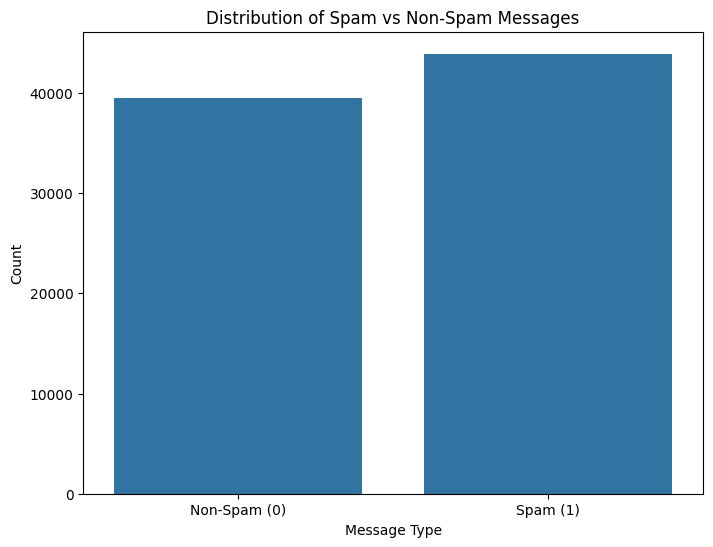

In [6]:
# a. Count plot of spam vs non-spam messages
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x=LABEL_COLUMN)
plt.title('Distribution of Spam vs Non-Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
# Set x-axis labels explicitly since labels are 0 and 1
plt.xticks([0, 1], ['Non-Spam (0)', 'Spam (1)'])
plt.show()


Generating Word Clouds...


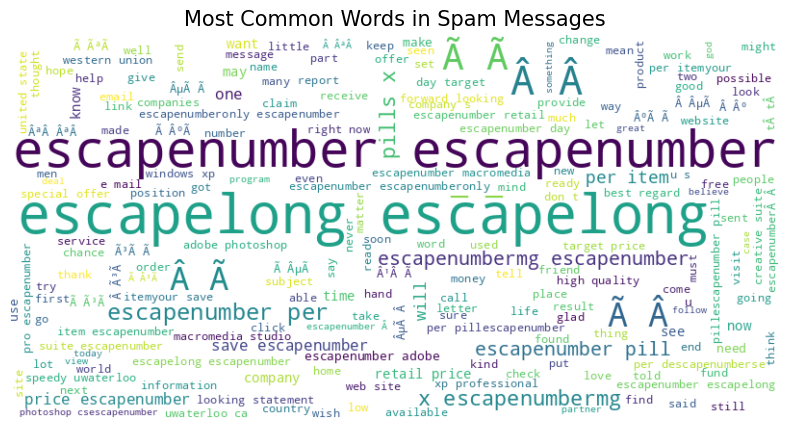

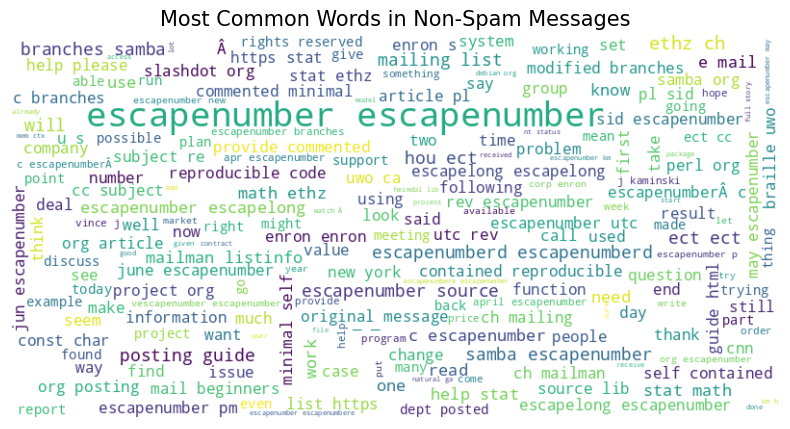

In [7]:
def generate_wordcloud(text, title):
    """
    Generates a word cloud from a string of text.
    """
    # Check if text is empty
    if not text:
        print(f"No text provided for '{title}'. Cannot generate word cloud.")
        return

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=200,
                          colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

print("\nGenerating Word Clouds...")
# Combine all text for each category
# Ensure handling of potential NaN values and convert to string
spam_text = ' '.join(df[df[LABEL_COLUMN] == 1][TEXT_COLUMN].dropna().astype(str))
ham_text = ' '.join(df[df[LABEL_COLUMN] == 0][TEXT_COLUMN].dropna().astype(str))

# Generate word clouds
generate_wordcloud(spam_text, 'Most Common Words in Spam Messages')
generate_wordcloud(ham_text, 'Most Common Words in Non-Spam Messages')


### Data Preprocessing using NLTK

In [8]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
print("\n--- Applying NLTK Preprocessing ---")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Applies NLTK preprocessing steps to raw text.
    """
    if pd.isna(text):
        return ""

    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stop words and stem/lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha() # Added check for isalpha()
    ]
    # Join tokens back into a string
    return ' '.join(processed_tokens)

print("Applying NLTK Preprocessing to the text column...")
df['Processed_Text'] = df[TEXT_COLUMN].apply(preprocess_text)

print("DataFrame after Preprocessing (showing Processed_Text column):")
display(df[[TEXT_COLUMN, 'Processed_Text', LABEL_COLUMN]].head())


--- Applying NLTK Preprocessing ---
Applying NLTK Preprocessing to the text column...
DataFrame after Preprocessing (showing Processed_Text column):


,text,Processed_Text,label
0,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...,1
1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...,1
2,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...,0
3,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...,1
4,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...,0


### Text Vectorization using CountVectorizer

In [10]:
print("\n--- Implementing CountVectorizer ---")
print("Applying CountVectorizer to the Processed_Text column...")
vectorizer = CountVectorizer(max_features=10000, min_df=2)

# Fit and transform the processed text
X = vectorizer.fit_transform(df['Processed_Text'])

# Get the vocabulary (words that correspond to the columns of X)
feature_names = vectorizer.get_feature_names_out()

print("CountVectorizer fitted and transformed the text.")
print(f"Shape of the vectorized feature matrix (X): {X.shape} (with max_features={vectorizer.max_features}, min_df={vectorizer.min_df})")

y = df[LABEL_COLUMN] # Assuming LABEL_COLUMN is defined (e.g., 'label')

print("\nShape of labels (y):", y.shape)



--- Implementing CountVectorizer ---
Applying CountVectorizer to the Processed_Text column...
CountVectorizer fitted and transformed the text.
Shape of the vectorized feature matrix (X): (83448, 10000) (with max_features=10000, min_df=2)

Shape of labels (y): (83448,)


### Using Tf-idf

In [11]:
print("\n--- Implementing TfidfVectorizer ---")
print("Applying TfidfVectorizer to the Processed_Text column...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=2)

# Fit and transform the processed text
# X_tfidf will be a sparse matrix containing the TF-IDF scores
X_tfidf = tfidf_vectorizer.fit_transform(df['Processed_Text'])
# Get the vocabulary (words that correspond to the columns of X_tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print("TfidfVectorizer fitted and transformed the text.")
print("Shape of the vectorized feature matrix (X_tfidf):", X_tfidf.shape)

y = df[LABEL_COLUMN]
print("\nShape of labels (y):", y.shape)


--- Implementing TfidfVectorizer ---
Applying TfidfVectorizer to the Processed_Text column...
TfidfVectorizer fitted and transformed the text.
Shape of the vectorized feature matrix (X_tfidf): (83448, 10000)

Shape of labels (y): (83448,)


### Using Word2Vec with Gemsim

In [12]:
print("\n--- Training Word2Vec Model with Processed Spam Detection Data ---")

sentences_for_w2v = [str(text).split() for text in df['Processed_Text'] if str(text).split()]

model = Word2Vec(sentences=sentences_for_w2v, vector_size=100, window=5, min_count=5, workers=4)

print("\nWord2Vec model training with spam detection data is complete.")

# Example 1: Find words similar to a given word
try:
    # Choose a word you expect to be frequent in your dataset (e.g., from your word clouds)
    word_to_explore = 'free'
    print(f"\nWords similar to '{word_to_explore}':")
    print(model.wv.most_similar(word_to_explore))
except KeyError:
    print(f"\n'{word_to_explore}' not found in the model's vocabulary.")

try:
    word_to_explore_2 = 'win'
    print(f"\nWords similar to '{word_to_explore_2}':")
    print(model.wv.most_similar(word_to_explore_2))
except KeyError:
    print(f"\n'{word_to_explore_2}' not found in the model's vocabulary.")

# Example 2: Get the vector for a word
try:
    word_for_vector = 'money'
    print(f"\nVector for '{word_for_vector}':")
    # Print only a few components of the vector for brevity
    print(model.wv[word_for_vector][:10], "...") # Print first 10 components
    print(f"Vector size: {len(model.wv[word_for_vector])}")
except KeyError:
    print(f"\n'{word_for_vector}' not found in the model's vocabulary.")

# Example 3: Calculate similarity between two words
try:
    word1 = 'call'
    word2 = 'text'
    print(f"\nSimilarity between '{word1}' and '{word2}':")
    print(model.wv.similarity(word1, word2))
except KeyError:
    print(f"\n'{word1}' or '{word2}' not found in the model's vocabulary.")

# Example 4: Perform a word analogy task (e.g., 'spam' - 'ham' + 'free' = ?)
# Choose words relevant to your spam/ham context that are likely in the vocabulary
try:
    analogy_result = model.wv.most_similar(positive=['spam', 'free'], negative=['ham'], topn=3)
    print("\nAnalogy: ('spam' + 'free') - 'ham' is similar to:")
    print(analogy_result)
except KeyError:
    print("\nOne or more words for the analogy ('spam', 'free', 'ham') not found in the model's vocabulary.")
except Exception as e:
    print(f"\nAn error occurred during the analogy query: {e}")


# Example 5: Check if a word is in the vocabulary
word_to_check = 'subscribe'
print(f"\nIs '{word_to_check}' in the vocabulary? {word_to_check in model.wv.key_to_index}")

word_to_check_2 = 'aardvark' # A word unlikely to be in your corpus
print(f"Is '{word_to_check_2}' in the vocabulary? {word_to_check_2 in model.wv.key_to_index}")


# Example 6: Get the size of the vocabulary
print(f"\nVocabulary size: {len(model.wv)}")




--- Training Word2Vec Model with Processed Spam Detection Data ---

Word2Vec model training with spam detection data is complete.

Words similar to 'free':
[('bonus', 0.46376681327819824), ('required', 0.45938608050346375), ('right', 0.4593515992164612), ('learn', 0.43355992436408997), ('sign', 0.4290506839752197), ('good', 0.42100927233695984), ('absolutely', 0.41656821966171265), ('immobilizers', 0.41349276900291443), ('usually', 0.413460373878479), ('today', 0.4104520380496979)]

Words similar to 'win':
[('victory', 0.5665794014930725), ('motorsport', 0.5218879580497742), ('championship', 0.5209046006202698), ('race', 0.5192903876304626), ('jackpot', 0.5075496435165405), ('wimbledon', 0.4984264373779297), ('âescapenumberm', 0.49564623832702637), ('preakness', 0.4928535521030426), ('play', 0.490373820066452), ('libere', 0.4847731292247772)]

Vector for 'money':
[ 0.9893647   5.0851464  -0.7124267   2.312303   -2.8867762  -1.5955199
 -0.20456268  2.0603447  -0.3510885   0.42074722] .